# 프로젝트 : 모든 장르 간 편향성 측정해 보기

## 루브릭

|평가문항|상세기준|
|:--|:--|
|1. 주어진 영화 코퍼스를 바탕으로 워드임베딩 모델을 정상적으로 만들었다.|워드임베딩의 most_similar() 메소드 결과가 의미상 바르게 나왔다.|
|2. 영화 구분, 장르별로 target, attribute에 대한 대표성있는 단어 셋을 생성하였다.|타당한 방법론을 통해 중복이 잘 제거되고 개념축을 의미적으로 잘 대표하는 단어 셋이 만들어졌다.|
|3. WEAT score 계산 및 시각화를 정상적으로 진행하였다.|전체 영화 장르별로 예술/일반 영화에 대한 편향성 WEAT score가 상식에 부합하는 수치로 얻어졌으며 이를 잘 시각화하였다.|

## 라이브러리 버전 확인

```python
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)
```
```python
0.5.2
4.1.2
1.0
0.11.2
```

In [2]:
!pip install konlpy

In [3]:
!pip install --upgrade gensim

In [4]:
import konlpy
import gensim
import sklearn
import seaborn

print(konlpy.__version__)
print(gensim.__version__)
print(sklearn.__version__)
print(seaborn.__version__)

0.6.0
4.1.2
1.0.2
0.11.2


# STEP 1. 형태소 분석기를 이용하여 품사가 명사인 경우 해당 단어를 추출하기

```
$ mkdir -p ~/aiffel/weat
$ ln -s ~/data/* ~/aiffel/weat/
$ cd ~/aiffel/weat
$ ls -l
$ wget https://aiffelstaticprd.blob.core.windows.net/media/documents/synopsis.zip
$ mv synopsis.zip ~/aiffel/weat
$ cd ~/aiffel/weat && unzip synopsis.zip
```

In [5]:
import os

with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    for i in range(20):
        print(file.readline(), end='')

사운드 엔지니어 상우(유지태 분)는 치매에 걸린 할머니(백성희 분)와
 젊은 시절 상처한 한 아버지(박인환 분), 고모(신신애 분)와 함께 살고 있다.
 어느 겨울 그는 지방 방송국 라디오 PD 은수(이영애 분)를 만난다.
 자연의 소리를 채집해 틀어주는 라디오 프로그램을 준비하는 은수는 상우와 녹음 여행을 떠난다.
 자연스레 가까워지는 두 사람은 어느 날, 은수의 아파트에서 밤을 보낸다.
 너무 쉽게 사랑에 빠진 두 사람... 상우는 주체할 수 없을 정도로 그녀에게 빨려든다.
 그러나 겨울에 만난 두 사람의 관계는 봄을 지나 여름을 맞이하면서 삐걱거린다.
 이혼 경험이 있는 은수는 상우에게 결혼할 생각이 없다며 부담스러운 표정을 내비친다.
 "어떻게 사랑이 변하니?..."라고 묻는 상우에게 은수는 그저 "헤어져" 라고 단호하게 말한다.
 영원히 변할 것 같지 않던 사랑이 변하고, 그 사실을 받아들이지 못하는 상우는 어찌 할 바를 모른다.
 은수를 잊지 못하는 상우는 미련과 집착의 감정을 이기지 못하고 서울과 강릉을 오간다.
유사 이래 연령, 성별, 빈부의 차이와 정치적인 입장을 불문하고 일거에 국민을 통합해 온 '애국심'이라는 성역에 일침을 가하는 다큐멘터리. 재작년 전국 민족민주 유가족협의회의 장기농성을 다룬 인상적인 다큐멘터리 <민들레>를 만들었던 독립영화집단 '빨간 눈사람'이 우리 사회 구석구석을 발빠르게 돌아다니며 애국심과 민족주의가 강요되는 현장을 발굴하여 카메라에 담았다. 박홍 서강대 명예총장, 이도형 '한국논단' 발행인, 축구해설자 신문선, 홍세화, 박노해 등 사회 각계의 '스타'들이 등장해 저마다의 확고한 신념을 성토한다. 감독 이경순과 최하동하는 이 작품을 위해 3년간 백여 명을 인터뷰했다고 한다. 2001 올해의 독립영화상 수상.
 민족과 국가란 공동체에서 부단히 권력과 부를 얻는 자, 나아가 민족과 국가란 공동체에서 얻은 신분과 부귀를 영원히 그의 자손에게 대물림하려는 자, 그래서 민족과 국가란 공동체를 부단히 유지해야만 하는 자, 따라서

In [6]:
# 약 15분정도 걸립니다.
from konlpy.tag import Okt
okt = Okt()
tokenized = []
with open(os.getenv('HOME')+'/aiffel/weat/synopsis.txt', 'r') as file:
    while True:
        line = file.readline()
        if not line: break
        words = okt.pos(line, stem=True, norm=True)
        res = []
        for w in words:
            if w[1] in ["Noun"]:      # "Adjective", "Verb" 등을 포함할 수도 있습니다.
                res.append(w[0])    # 명사일 때만 tokenized 에 저장하게 됩니다. 
        tokenized.append(res)

In [7]:
print(len(tokenized))

71156


# STEP 2. 추출된 결과로 embedding model 만들기

In [8]:
from gensim.models import Word2Vec

# tokenized에 담긴 데이터를 가지고 나만의 Word2Vec을 생성합니다. (Gensim 4.0 기준)
model = Word2Vec(tokenized, vector_size=100, window=5, min_count=3, sg=0)  
model.wv.most_similar(positive=['영화'])

# Gensim 3.X 에서는 아래와 같이 생성합니다. 
# model = Word2Vec(tokenized, size=100, window=5, min_count=3, sg=0)  
# model.most_similar(positive=['영화'])

[('작품', 0.8721688985824585),
 ('다큐멘터리', 0.8426090478897095),
 ('드라마', 0.8253313302993774),
 ('영화로', 0.8098037242889404),
 ('주제', 0.7905721664428711),
 ('형식', 0.7881203293800354),
 ('코미디', 0.7815738320350647),
 ('소재', 0.7704669833183289),
 ('스토리', 0.7691568732261658),
 ('영상', 0.7615275979042053)]

In [9]:
model.wv.most_similar(positive=['사랑'])

[('행복', 0.7345945835113525),
 ('가슴', 0.7182921767234802),
 ('첫사랑', 0.7060811519622803),
 ('만남', 0.7050251364707947),
 ('이별', 0.6922241449356079),
 ('애정', 0.6895290613174438),
 ('진심', 0.6876256465911865),
 ('고백', 0.6864861845970154),
 ('아픔', 0.6827253699302673),
 ('감정', 0.6803959012031555)]

In [10]:
model.wv.most_similar(positive=['연극'])

[('영감', 0.8812835216522217),
 ('영화감독', 0.8794596195220947),
 ('시나리오', 0.87298983335495),
 ('배우', 0.8679670691490173),
 ('대본', 0.8675619959831238),
 ('감성', 0.8616877198219299),
 ('각색', 0.8609178066253662),
 ('예술가', 0.857399046421051),
 ('데뷔', 0.856251060962677),
 ('곡', 0.8540966510772705)]

# STEP 3. target, attribute 단어 셋 만들기

- 영화 구분
    - synopsis_art.txt : 예술영화

    - synopsis_gen.txt : 일반영화(상업영화)
    
    - 그 외는 독립영화 등으로 분류됩니다.

- 장르 구분
    - synopsis_SF.txt: SF

    - synopsis_가족.txt: 가족

    - synopsis_공연.txt: 공연

    - synopsis_공포(호러).txt: 공포(호러)

    - synopsis_기타.txt: 기타

    - synopsis_다큐멘터리.txt: 다큐멘터리

    - synopsis_드라마.txt: 드라마

    - synopsis_멜로로맨스.txt: 멜로로맨스

    - synopsis_뮤지컬.txt: 뮤지컬

    - synopsis_미스터리.txt: 미스터리

    - synopsis_범죄.txt: 범죄

    - synopsis_사극.txt: 사극

    - synopsis_서부극(웨스턴).txt: 서부극(웨스턴)

    - synopsis_성인물(에로).txt: 성인물(에로)

    - synopsis_스릴러.txt: 스릴러

    - synopsis_애니메이션.txt: 애니메이션

    - synopsis_액션.txt: 액션

    - synopsis_어드벤처.txt: 어드벤처

    - synopsis_전쟁.txt: 전쟁

    - synopsis_코미디.txt: 코미디

    - synopsis_판타지.txt: 판타지

In [11]:
import os
from sklearn.feature_extraction.text import TfidfVectorizer
import numpy as np
from konlpy.tag import Okt

art_txt = 'synopsis_art.txt'
gen_txt = 'synopsis_gen.txt'

def read_token(file_name):
    okt = Okt()
    result = []
    with open(os.getenv('HOME')+'/aiffel/weat/'+file_name, 'r') as fread: 
        print(file_name, '파일을 읽고 있습니다.')
        while True:
            line = fread.readline() 
            if not line: break 
            tokenlist = okt.pos(line, stem=True, norm=True) 
            for word in tokenlist:
                if word[1] in ["Noun"]:#, "Adjective", "Verb"]:
                    result.append((word[0])) 
    return ' '.join(result)

In [12]:
# 2개의 파일을 처리하는데 10분 가량 걸립니다. 
art = read_token(art_txt)
gen = read_token(gen_txt)

synopsis_art.txt 파일을 읽고 있습니다.
synopsis_gen.txt 파일을 읽고 있습니다.


## TF-IDF

In [13]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform([art, gen])

print(X.shape)

(2, 41082)


In [14]:
print(vectorizer.vocabulary_['영화'])
print(vectorizer.get_feature_names()[23976])

23976
영화


In [15]:
m1 = X[0].tocoo()   # art를 TF-IDF로 표현한 sparse matrix를 가져옵니다. 
m2 = X[1].tocoo()   # gen을 TF-IDF로 표현한 sparse matrix를 가져옵니다. 

w1 = [[i, j] for i, j in zip(m1.col, m1.data)]
w2 = [[i, j] for i, j in zip(m2.col, m2.data)]

w1.sort(key=lambda x: x[1], reverse=True)   #art를 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 
w2.sort(key=lambda x: x[1], reverse=True)   #gen을 구성하는 단어들을 TF-IDF가 높은 순으로 정렬합니다. 

print('예술영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w1[i][0]], end=', ')

print('\n')
    
print('일반영화를 대표하는 단어들:')
for i in range(100):
    print(vectorizer.get_feature_names()[w2[i][0]], end=', ')

예술영화를 대표하는 단어들:
그녀, 자신, 시작, 위해, 사랑, 사람, 영화, 친구, 남자, 가족, 이야기, 마을, 사건, 마음, 세상, 아버지, 아이, 엄마, 모든, 여자, 대한, 서로, 과연, 다시, 시간, 아들, 소녀, 아내, 다른, 사이, 영화제, 세계, 사실, 하나, 점점, 남편, 감독, 여행, 인생, 발견, 모두, 순간, 우리, 가장, 마지막, 생활, 아빠, 모습, 통해, 죽음, 기억, 비밀, 학교, 음악, 한편, 소년, 생각, 도시, 명의, 사고, 결혼, 전쟁, 때문, 위기, 이제, 최고, 이자, 과거, 일상, 경찰, 상황, 간다, 미국, 결심, 운명, 현실, 관계, 지금, 단편, 여인, 하루, 이름, 이후, 준비, 인간, 감정, 만난, 국제, 처음, 충격, 살인, 누구, 동안, 존재, 그린, 어머니, 연인, 계속, 동생, 작품, 

일반영화를 대표하는 단어들:
자신, 그녀, 영화제, 위해, 사람, 시작, 국제, 영화, 친구, 사랑, 남자, 이야기, 대한, 서울, 여자, 사건, 남편, 아이, 가족, 아버지, 다른, 마을, 시간, 엄마, 아들, 모든, 단편, 마음, 사실, 다시, 세계, 모습, 작품, 통해, 생각, 서로, 세상, 발견, 감독, 아내, 관계, 소녀, 사이, 하나, 우리, 애니메이션, 때문, 여성, 죽음, 과연, 점점, 인간, 생활, 한편, 결혼, 상황, 모두, 기억, 명의, 소년, 여행, 가장, 간다, 순간, 이제, 도시, 비밀, 학교, 과거, 가지, 이자, 경찰, 마지막, 미국, 동안, 전쟁, 주인공, 대해, 존재, 현실, 연출, 사고, 살인, 일상, 어머니, 계속, 사회, 인생, 다큐멘터리, 부문, 섹스, 최고, 바로, 동생, 의도, 하루, 위기, 계획, 정체, 한국, 

In [16]:
# 중복 제거
n = 15
w1_, w2_ = [], []
for i in range(100):
    w1_.append(vectorizer.get_feature_names()[w1[i][0]])
    w2_.append(vectorizer.get_feature_names()[w2[i][0]])

# w1에만 있고 w2에는 없는, 예술영화를 잘 대표하는 단어를 15개 추출한다.
target_art, target_gen = [], []
for i in range(100):
    if (w1_[i] not in w2_) and (w1_[i] in model.wv): target_art.append(w1_[i])
    if len(target_art) == n: break 

# w2에만 있고 w1에는 없는, 일반영화를 잘 대표하는 단어를 15개 추출한다.
for i in range(100):
    if (w2_[i] not in w1_) and (w2_[i] in model.wv): target_gen.append(w2_[i])
    if len(target_gen) == n: break

In [17]:
print(target_art)

['아빠', '음악', '결심', '운명', '지금', '여인', '이름', '이후', '준비', '감정', '만난', '처음', '충격', '누구', '그린']


In [18]:
print(target_gen)

['서울', '애니메이션', '여성', '가지', '주인공', '대해', '연출', '사회', '다큐멘터리', '부문', '섹스', '바로', '의도', '계획', '정체']


In [19]:
genre_txt = ['synopsis_SF.txt', 'synopsis_family.txt', 'synopsis_show.txt', 'synopsis_horror.txt', 'synopsis_etc.txt', 
             'synopsis_documentary.txt', 'synopsis_drama.txt', 'synopsis_romance.txt', 'synopsis_musical.txt', 
             'synopsis_mystery.txt', 'synopsis_crime.txt', 'synopsis_historical.txt', 'synopsis_western.txt', 
             'synopsis_adult.txt', 'synopsis_thriller.txt', 'synopsis_animation.txt', 'synopsis_action.txt', 
             'synopsis_adventure.txt', 'synopsis_war.txt', 'synopsis_comedy.txt', 'synopsis_fantasy.txt']
genre_name = ['SF', '가족', '공연', '공포(호러)', '기타', '다큐멘터리', '드라마', '멜로로맨스', '뮤지컬', '미스터리', '범죄', '사극', '서부극(웨스턴)',
         '성인물(에로)', '스릴러', '애니메이션', '액션', '어드벤처', '전쟁', '코미디', '판타지']

In [20]:
# 약 10분정도 걸립니다.
genre = []
for file_name in genre_txt:
    genre.append(read_token(file_name))

synopsis_SF.txt 파일을 읽고 있습니다.
synopsis_family.txt 파일을 읽고 있습니다.
synopsis_show.txt 파일을 읽고 있습니다.
synopsis_horror.txt 파일을 읽고 있습니다.
synopsis_etc.txt 파일을 읽고 있습니다.
synopsis_documentary.txt 파일을 읽고 있습니다.
synopsis_drama.txt 파일을 읽고 있습니다.
synopsis_romance.txt 파일을 읽고 있습니다.
synopsis_musical.txt 파일을 읽고 있습니다.
synopsis_mystery.txt 파일을 읽고 있습니다.
synopsis_crime.txt 파일을 읽고 있습니다.
synopsis_historical.txt 파일을 읽고 있습니다.
synopsis_western.txt 파일을 읽고 있습니다.
synopsis_adult.txt 파일을 읽고 있습니다.
synopsis_thriller.txt 파일을 읽고 있습니다.
synopsis_animation.txt 파일을 읽고 있습니다.
synopsis_action.txt 파일을 읽고 있습니다.
synopsis_adventure.txt 파일을 읽고 있습니다.
synopsis_war.txt 파일을 읽고 있습니다.
synopsis_comedy.txt 파일을 읽고 있습니다.
synopsis_fantasy.txt 파일을 읽고 있습니다.


In [21]:
vectorizer = TfidfVectorizer()
X = vectorizer.fit_transform(genre)

print(X.shape)

(21, 42191)


In [22]:
m = [X[i].tocoo() for i in range(X.shape[0])]

w = [[[i, j] for i, j in zip(mm.col, mm.data)] for mm in m]

for i in range(len(w)):
    w[i].sort(key=lambda x: x[1], reverse=True)
attributes = []
for i in range(len(w)):
    print(genre_name[i], end=': ')
    attr = []
    j = 0
    while (len(attr) < 15):
        if vectorizer.get_feature_names()[w[i][j][0]] in model.wv:
            attr.append(vectorizer.get_feature_names()[w[i][j][0]])
            print(vectorizer.get_feature_names()[w[i][j][0]], end=', ')
        j += 1
    attributes.append(attr)
    print()

SF: 위해, 자신, 지구, 시작, 사람, 인류, 인간, 미래, 우주, 그녀, 로봇, 세계, 모든, 박사, 우주선, 
가족: 엄마, 아빠, 가족, 영화제, 자신, 위해, 친구, 아주르, 아버지, 시작, 그녀, 아들, 마을, 국제, 낙타, 
공연: 오페라, 사랑, 토스카, 실황, 올레, 자신, 카바, 그녀, 공연, 오텔로, 리골레토, 백작, 프레, 베르디, 위해, 
공포(호러): 시작, 위해, 사람, 자신, 친구, 그녀, 사건, 공포, 발견, 죽음, 마을, 가족, 악령, 남자, 좀비, 
기타: 영화제, 국제, 서울, 단편, 영화, 자신, 사람, 이야기, 그녀, 남자, 위해, 시작, 사랑, 뉴미디어, 페스티벌, 
다큐멘터리: 영화제, 영화, 다큐, 국제, 다큐멘터리, 사람, 이야기, 대한, 자신, 감독, 위해, 서울, 우리, 시작, 세계, 
드라마: 자신, 영화제, 그녀, 사람, 사랑, 영화, 위해, 시작, 국제, 남자, 친구, 이야기, 엄마, 여자, 아버지, 
멜로로맨스: 그녀, 사랑, 자신, 시작, 남편, 남자, 여자, 사람, 친구, 섹스, 위해, 마음, 결혼, 서로, 아내, 
뮤지컬: 뮤지컬, 사랑, 에스메랄다, 그녀, 음악, 충무로, 모차르트, 영화, 토스카, 자신, 니웨, 카바, 영화제, 바흐, 페뷔스, 
미스터리: 사건, 그녀, 시작, 자신, 위해, 사람, 발견, 사고, 진실, 죽음, 기억, 살인, 친구, 아내, 남자, 
범죄: 사건, 위해, 자신, 경찰, 시작, 그녀, 범죄, 조직, 살인, 사람, 마약, 형사, 남자, 모든, 살해, 
사극: 조선, 위해, 시작, 신기전, 사랑, 자신, 아가멤논, 황제, 그녀, 루안, 최고, 운명, 사람, 하선, 전쟁, 
서부극(웨스턴): 서부, 보안관, 위해, 벌린, 카우보이, 그레이프바인, 헨리, 마을, 자신, 개릿, 아이, 시작, 무법자, 프린트, 마적, 
성인물(에로): 그녀, 남편, 마사지, 자신, 섹스, 관계, 영화, 정사, 남자, 위해, 시작, 여자, 유부녀, 마음, 사랑, 
스릴러: 자신, 그녀, 사건, 

# STEP 4. WEAT score 계산과 시각화

In [23]:
import numpy as np
from numpy import dot
from numpy.linalg import norm

In [24]:
def cos_sim(i, j):
    return dot(i, j.T)/(norm(i)*norm(j))


def s(w, A, B):
    c_a = cos_sim(w, A)
    c_b = cos_sim(w, B)
    mean_A = np.mean(c_a, axis=-1)
    mean_B = np.mean(c_b, axis=-1)
    return mean_A - mean_B #, c_a, c_b


def weat_score(X, Y, A, B):
    
    s_X = s(X, A, B)
    s_Y = s(Y, A, B)

    mean_X = np.mean(s_X)
    mean_Y = np.mean(s_Y)
    
    std_dev = np.std(np.concatenate([s_X, s_Y], axis=0))
    
    return  (mean_X - mean_Y) / std_dev

- `attribute A`, `attribute B` : 영화 장르를 유연하게 선택
- `target X` : art, 예술영화
- `target Y` : gen, 일반영화

In [25]:
matrix = [[0 for _ in range(len(genre_name))] for _ in range(len(genre_name))]

In [26]:
X = np.array([model.wv[word] for word in target_art])
Y = np.array([model.wv[word] for word in target_gen])

for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        A = np.array([model.wv[word] for word in attributes[i]])
        B = np.array([model.wv[word] for word in attributes[j]])
        matrix[i][j] = weat_score(X, Y, A, B)

In [27]:
for i in range(len(genre_name)-1):
    for j in range(i+1, len(genre_name)):
        if matrix[i][j] > 0.8 or matrix[i][j] < -0.8:
            print(genre_name[i], genre_name[j],matrix[i][j])

SF 멜로로맨스 -0.8098648
SF 사극 -0.89973325
가족 다큐멘터리 0.8536088
가족 애니메이션 0.88947546
공연 기타 0.94312537
공연 다큐멘터리 0.94436204
공연 뮤지컬 0.8937292
공연 애니메이션 0.9528354
기타 드라마 -0.8868381
기타 멜로로맨스 -0.9085569
기타 사극 -0.8491504
기타 성인물(에로) -0.838198
다큐멘터리 드라마 -0.9392773
다큐멘터리 멜로로맨스 -0.922123
다큐멘터리 사극 -0.9420222
다큐멘터리 성인물(에로) -0.860931
다큐멘터리 어드벤처 -0.9557424
다큐멘터리 코미디 -0.8508806
다큐멘터리 판타지 -0.9137723
드라마 멜로로맨스 -0.86237866
드라마 뮤지컬 0.8266458
드라마 애니메이션 0.9076743
멜로로맨스 뮤지컬 0.87824506
멜로로맨스 범죄 0.82961494
멜로로맨스 성인물(에로) 0.81721276
멜로로맨스 애니메이션 0.90118974
멜로로맨스 전쟁 0.8046543
멜로로맨스 코미디 0.91180277
멜로로맨스 판타지 0.8536942
뮤지컬 사극 -0.81889766
뮤지컬 성인물(에로) -0.80965674
미스터리 범죄 0.9573428
범죄 스릴러 -0.9485171
사극 애니메이션 0.88596416
사극 전쟁 0.9019315
애니메이션 어드벤처 -0.90711975


## 시각화

In [28]:
# Colab 한글 깨짐
# !sudo apt-get install -y fonts-nanum
# !sudo fc-cache -fv
# !rm ~/.cache/matplotlib -rf

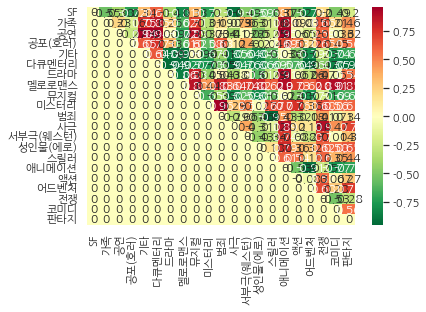

In [29]:
import numpy as np; 
import seaborn as sns; 
import matplotlib.pyplot as plt;

import warnings
warnings.filterwarnings('ignore')

np.random.seed(0)

# 한글 지원 폰트
sns.set(font='NanumGothic')

# 마이너스 부호 
plt.rcParams['axes.unicode_minus'] = False

ax = sns.heatmap(matrix, xticklabels=genre_name, yticklabels=genre_name, annot=True,  cmap='RdYlGn_r')
ax;

# 회고

- 이전에 NLP를 접해봤지만 생소한 내용이어서 공부하게 되어 좋았고 좀 더 정리를 통해서 이해를 해야겠다고 생각했다.
- 아직 이해가 완벽히 되지 않았지만 노드의 내용과 크게 다르지 않아서 따라가며 어느 정도 이해를 해보았다.